In [1]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

In [12]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False, node_color=color, cmap="Set2")
    plt.show()
    
def visualize_embedding(h, color,epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [3]:
from torch_geometric.datasets import KarateClub
dataset = KarateClub()
print(f'Datasets:{dataset}')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Datasets:KarateClub()
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [4]:
data = dataset[0]
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


### Edge_index
- edge_index:表示图的连接关系（start,end两个序列）
- node_features:每个点的特征
- node_labels: 每个点的标签
- train_mask:有的节点木有标签（用来表示哪些节点要计算损失）

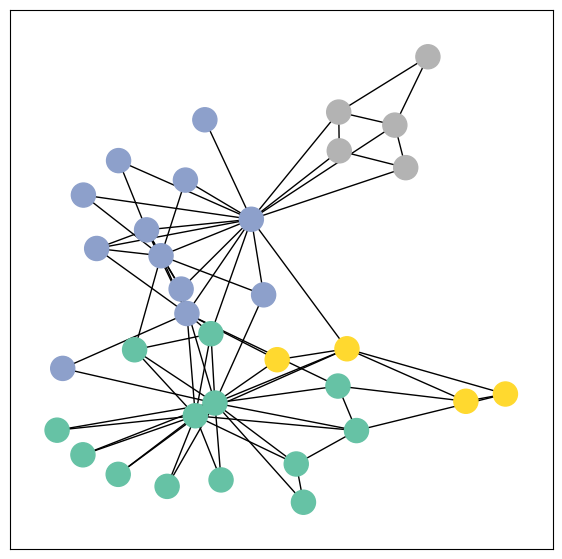

In [7]:
from torch_geometric.utils import to_networkx
G = to_networkx(data, to_undirected=True)
visualize_graph(G,color=data.y)

In [9]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)
        
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()
        
        # 分类曾
        out = self.classifier(h)
        
        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


### 输出特征展示

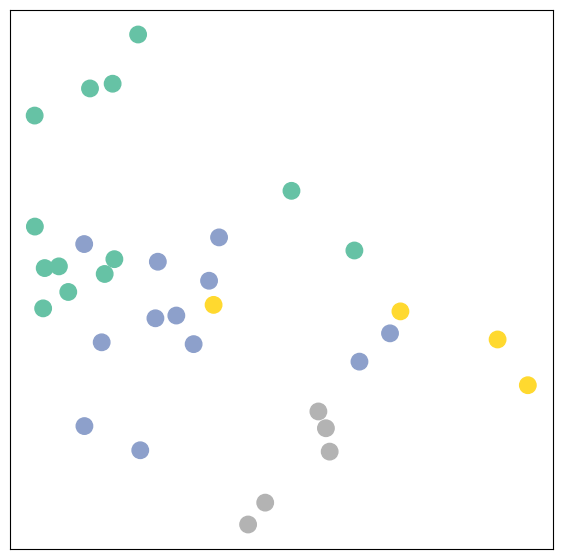

In [13]:
model = GCN()
_, h = model(data.x, data.edge_index)
visualize_embedding(h, color=data.y)

### 模型训练

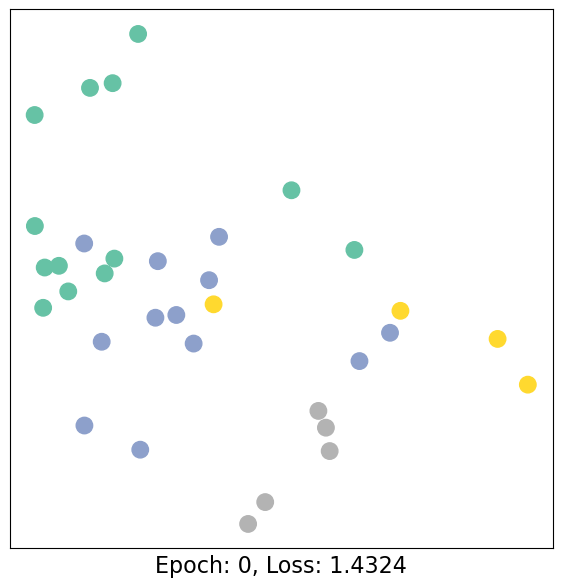

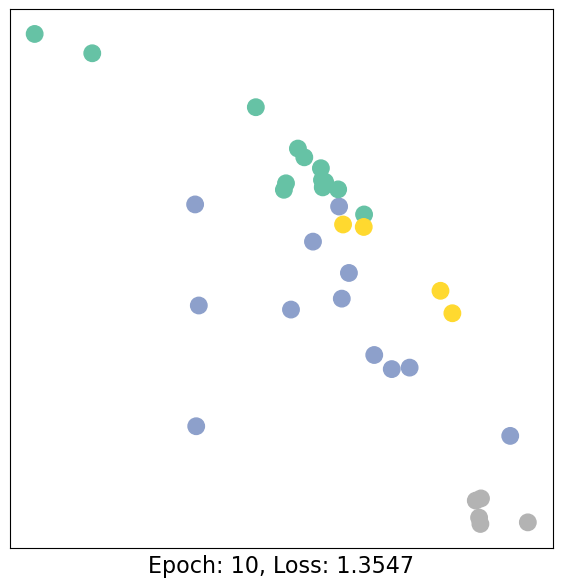

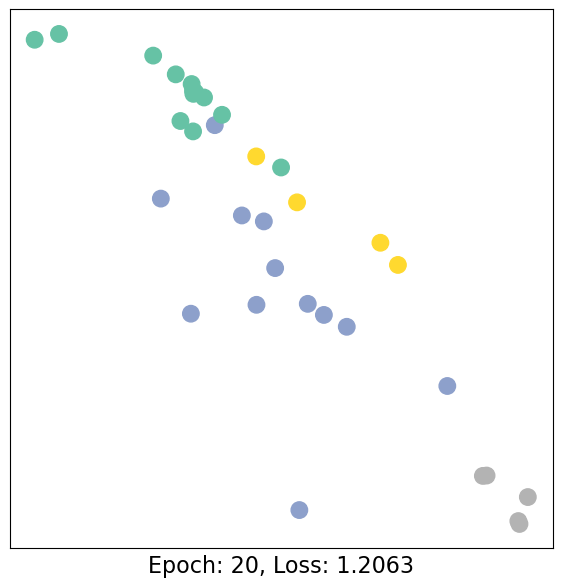

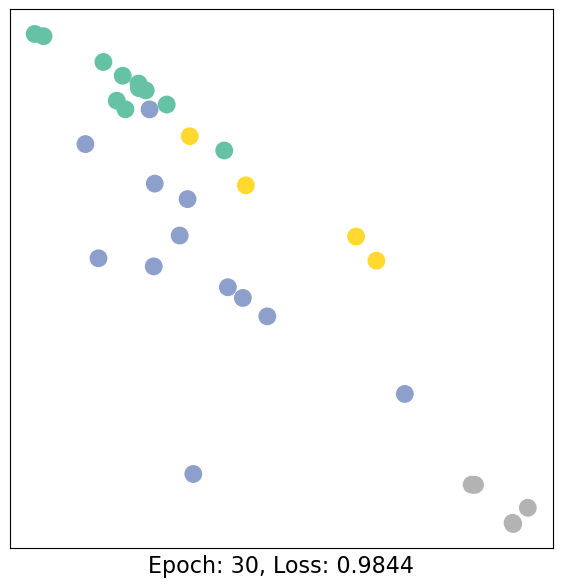

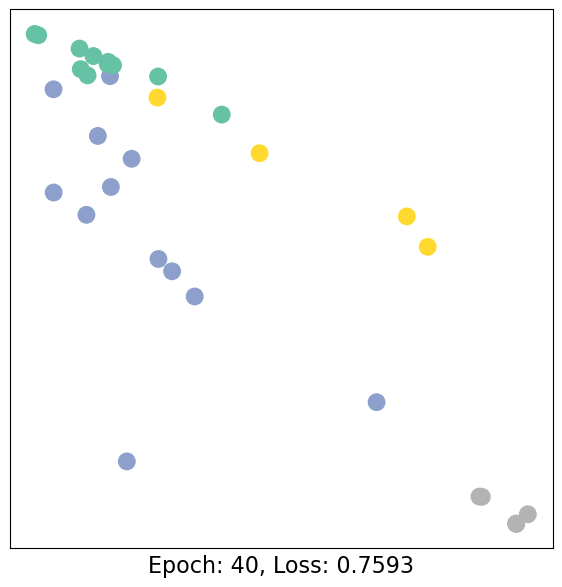

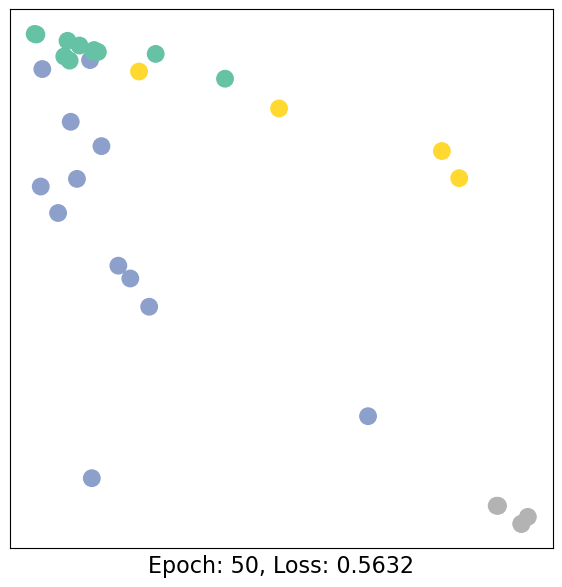

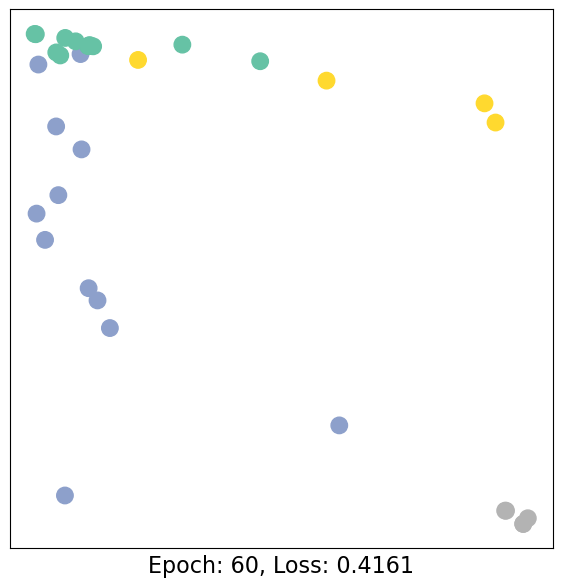

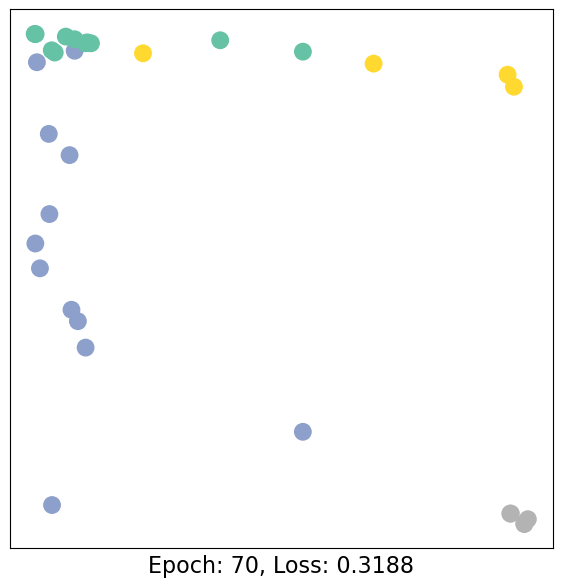

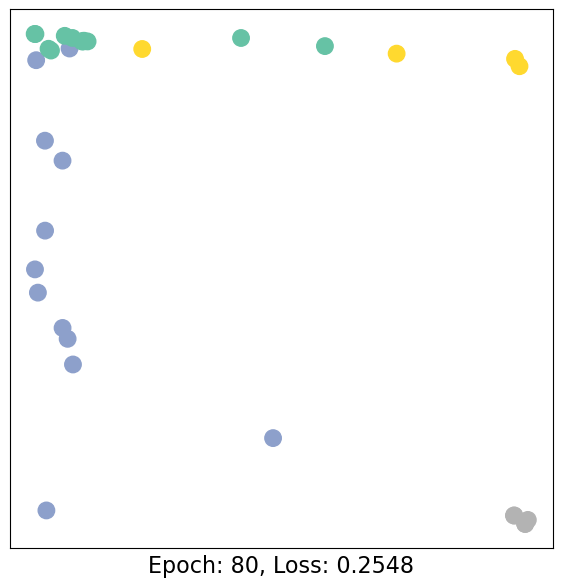

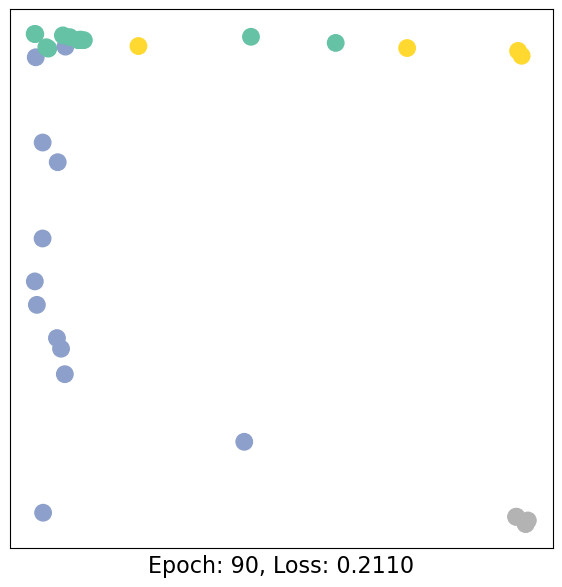

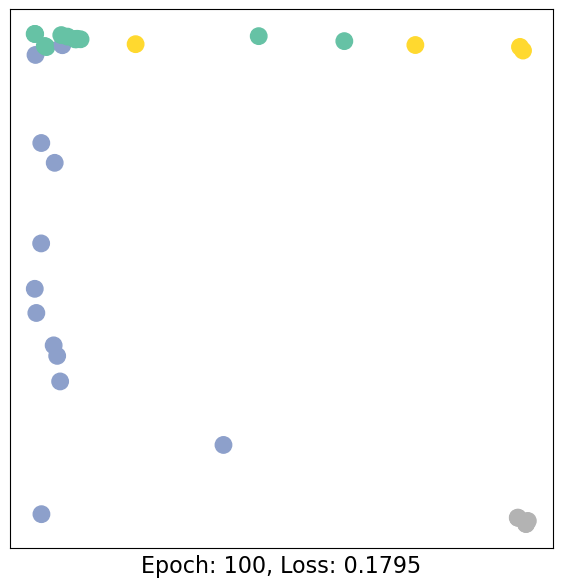

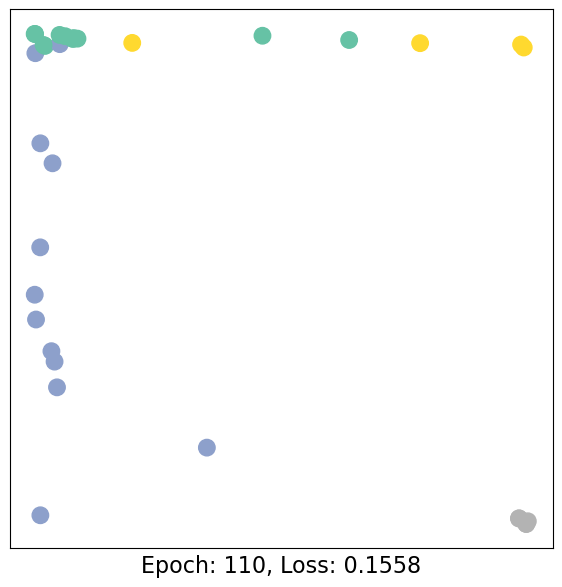

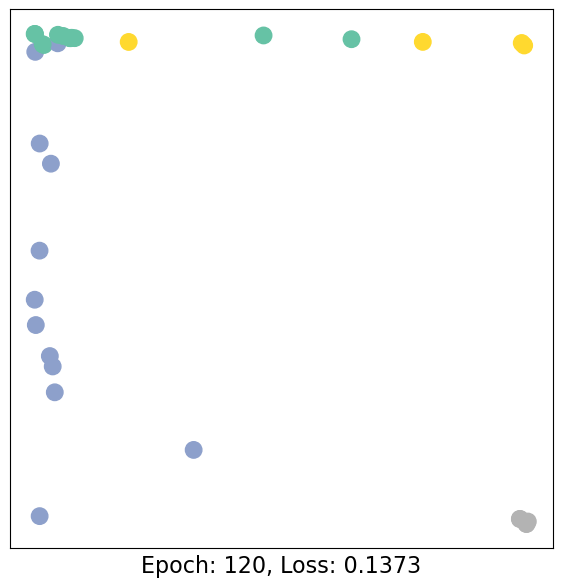

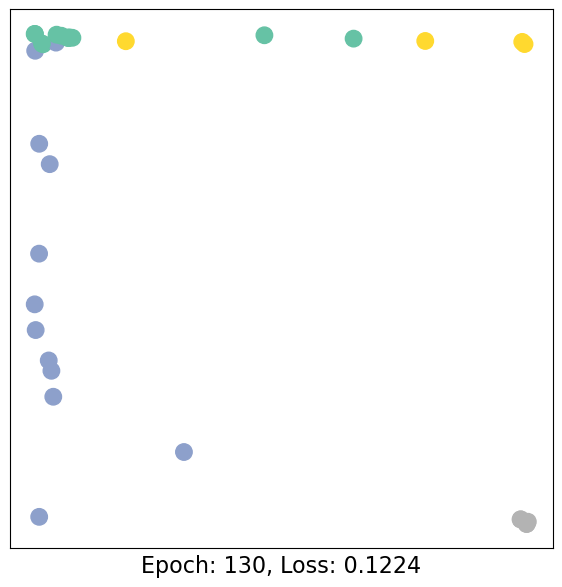

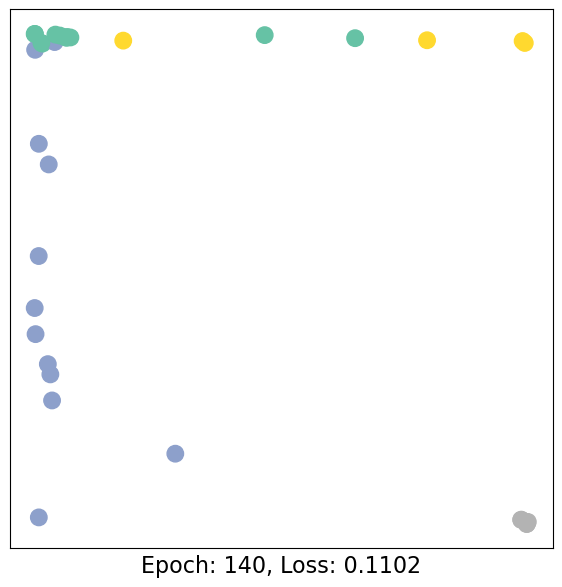

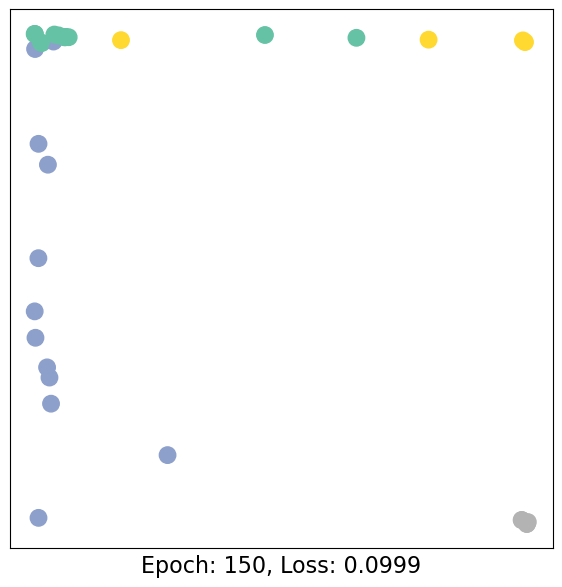

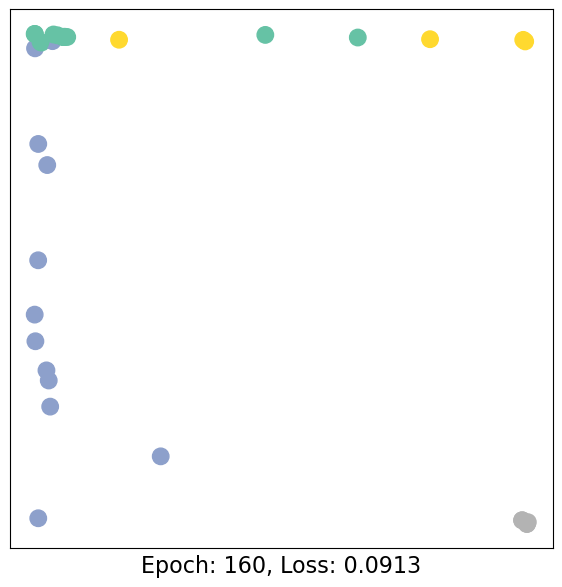

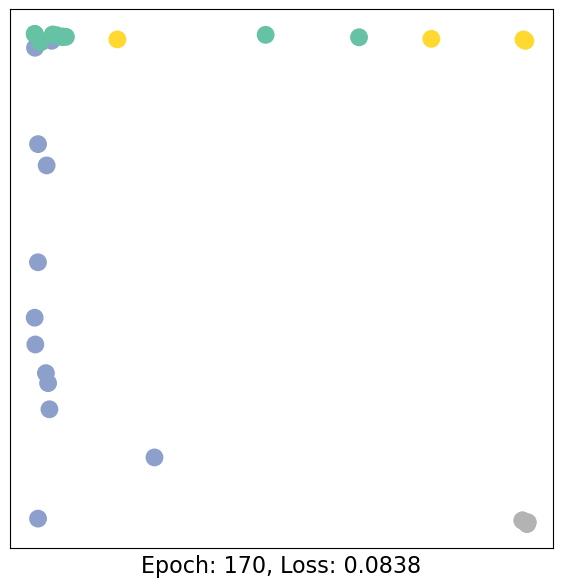

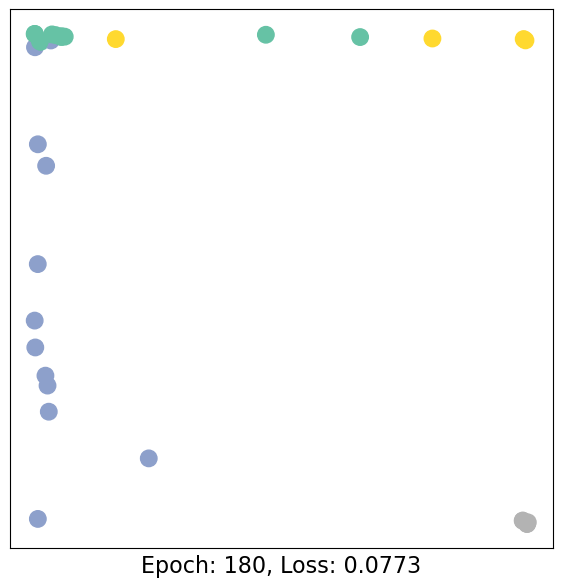

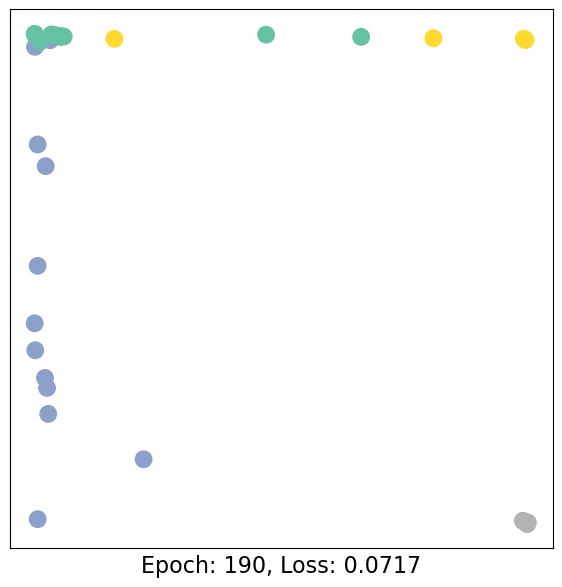

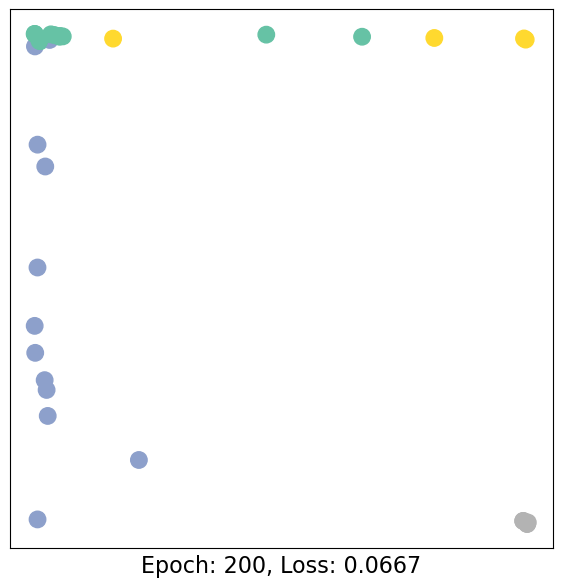

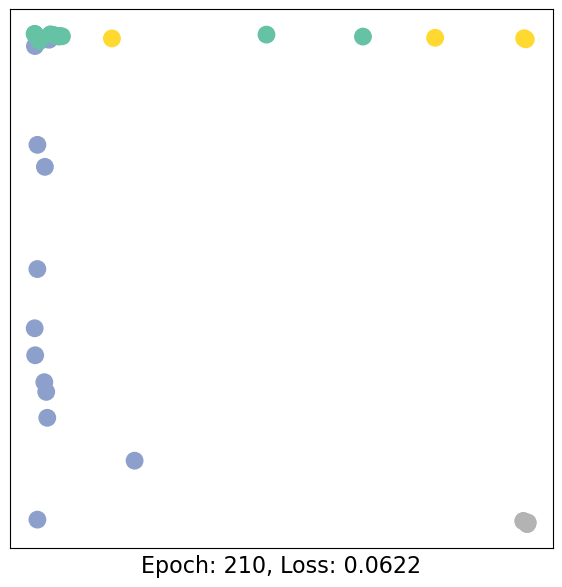

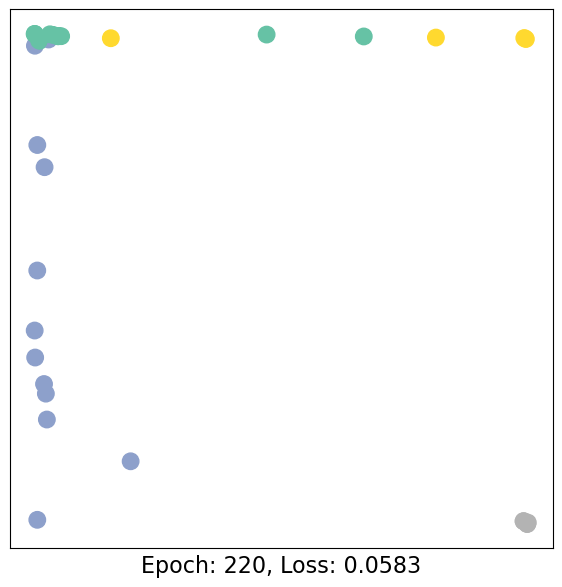

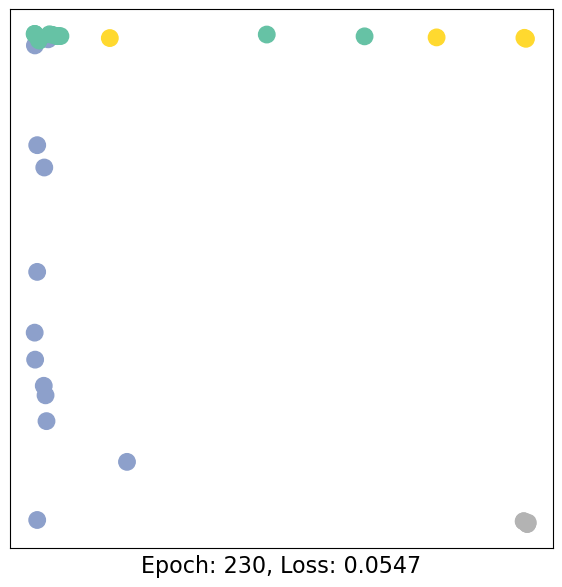

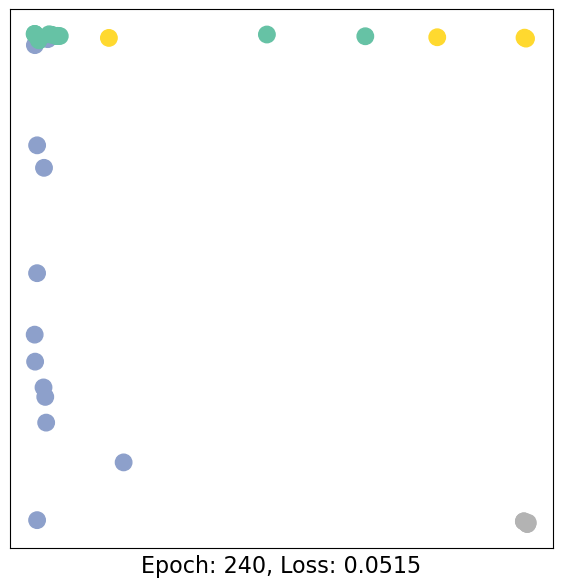

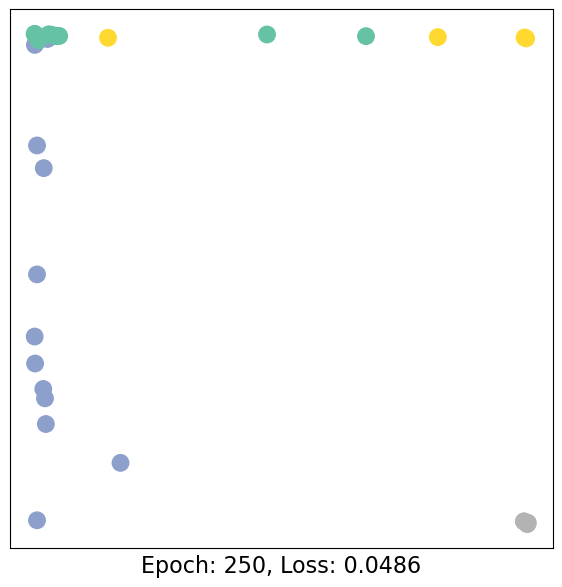

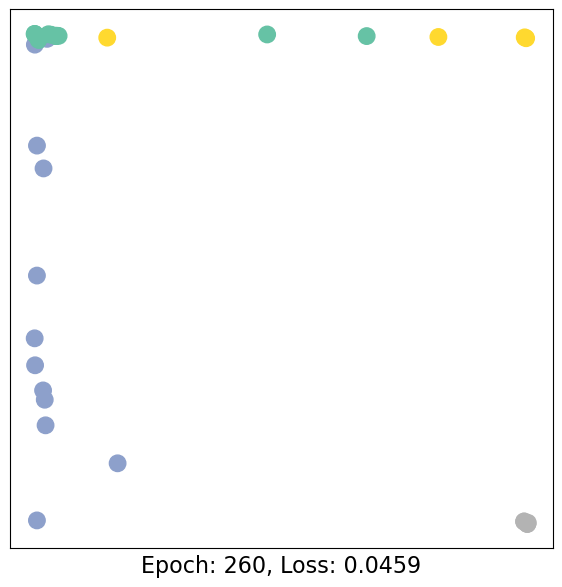

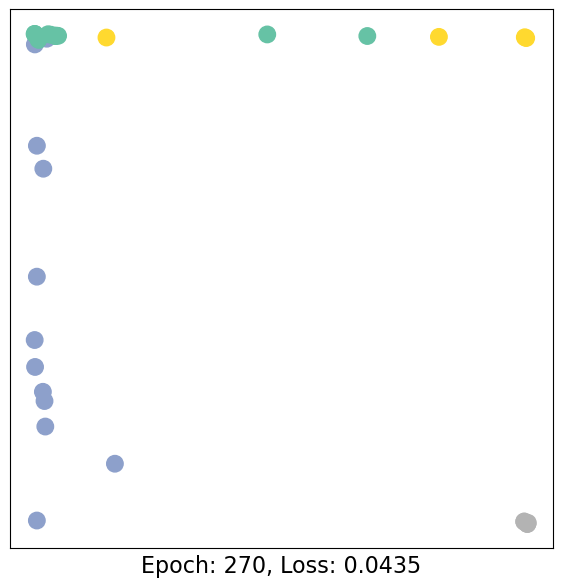

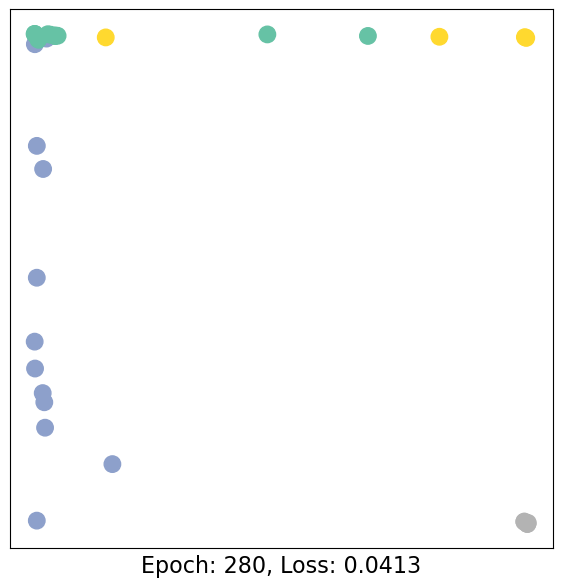

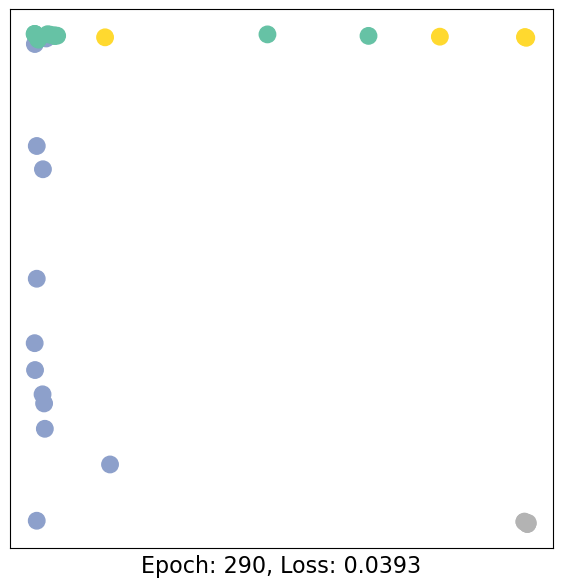

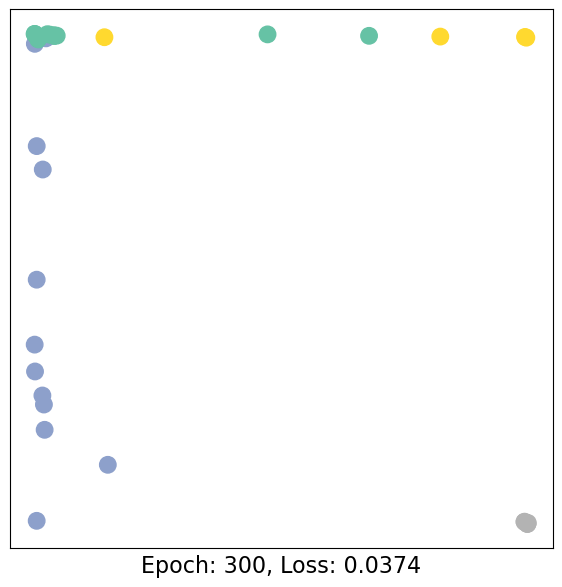

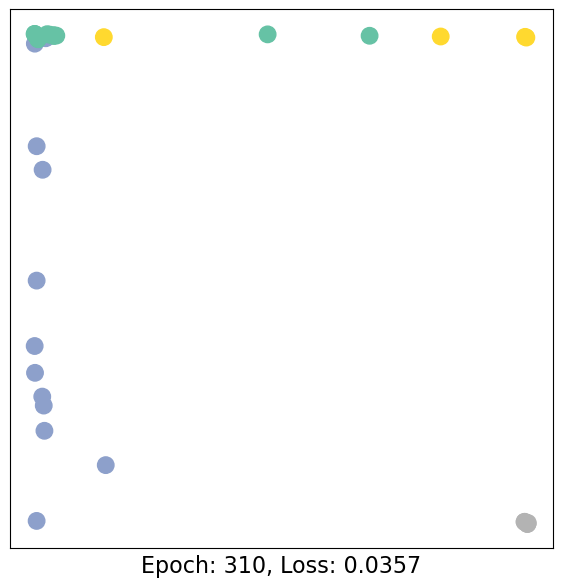

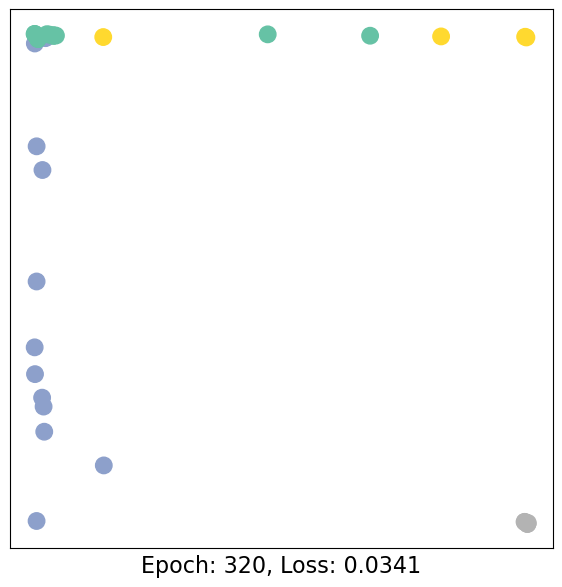

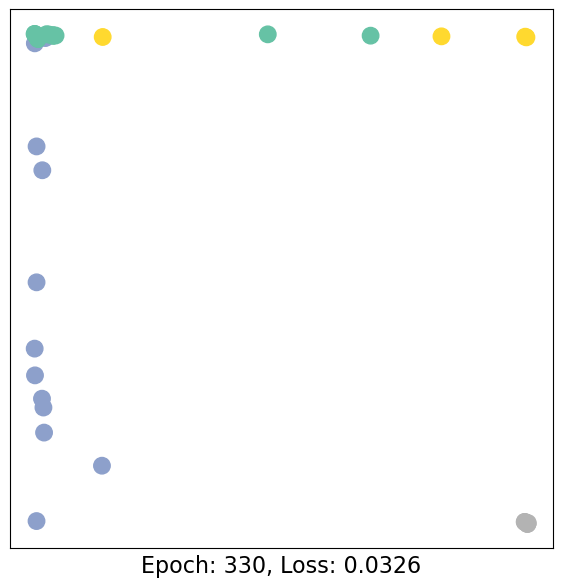

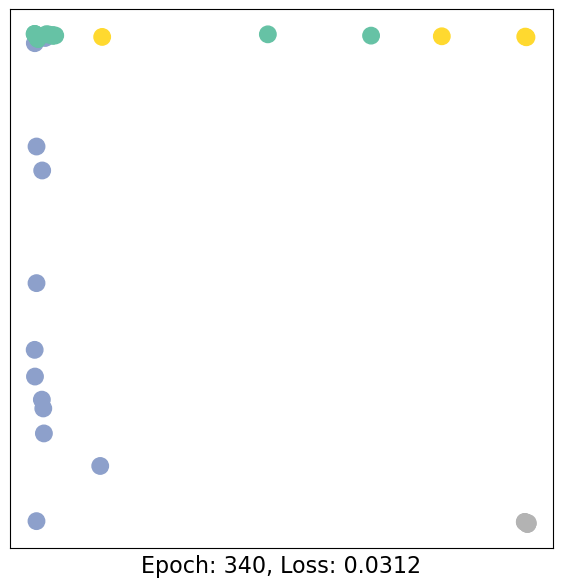

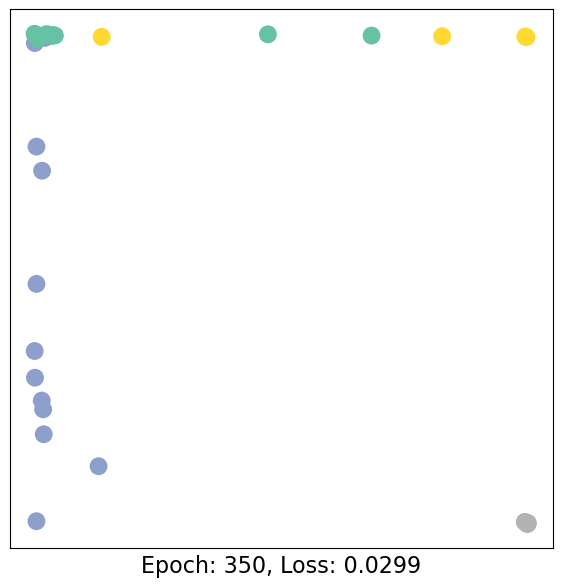

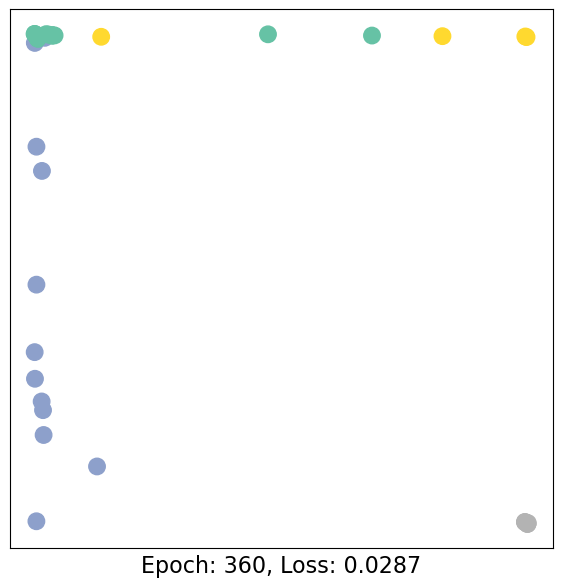

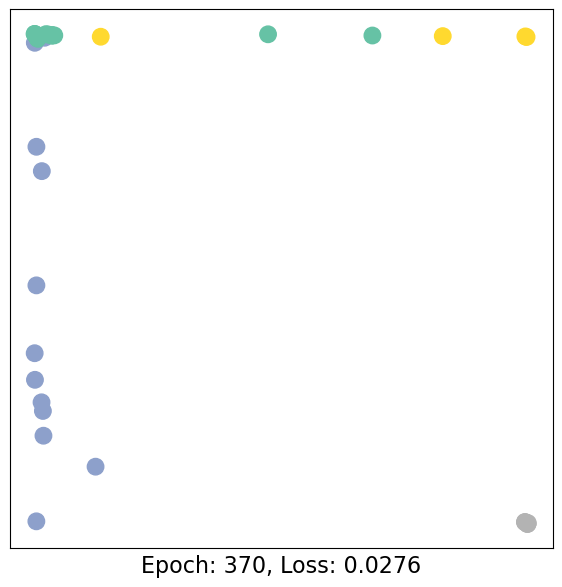

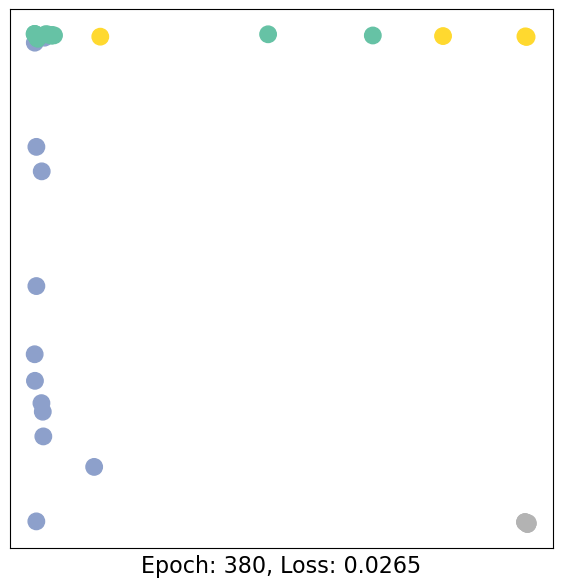

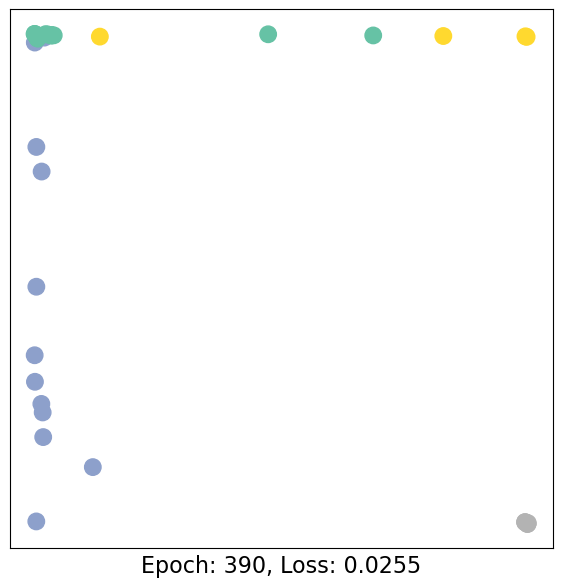

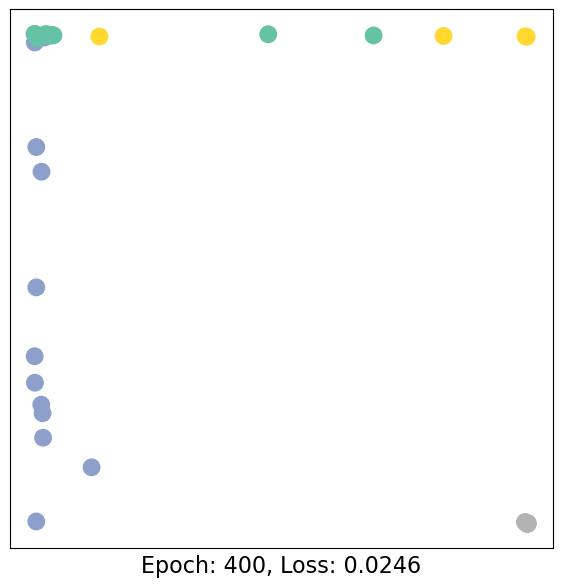

In [14]:
import time
model = GCN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(data):
    optimizer.zero_grad()
    out, h = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)